In [1]:
notebook_mode = True
viz_mode = True

In [2]:
import os
import json
import argparse
import time

import numpy as np

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt

import networkx as nx
from sklearn.utils.class_weight import compute_class_weight

from tensorboardX import SummaryWriter
from fastprogress import master_bar, progress_bar

# Remove warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter('ignore', SparseEfficiencyWarning)

from config import *
from utils.graph_utils import *
from utils.mst_reader import MSTReader
from utils.plot_utils import *
from models.gcn_model import ResidualGatedGCNModel
from utils.model_utils import *
from IPython import embed

In [3]:
if notebook_mode == True:
    %load_ext autoreload
    %autoreload 2
    %matplotlib inline
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('png')

# Load configurations

In [4]:
if notebook_mode==False:
    parser = argparse.ArgumentParser(description='gcn_tsp_parser')
    parser.add_argument('-c','--config', type=str, default="configs/default.json")
    args = parser.parse_args()
    config_path = args.config
else:
    config_path = "configs/default_mst.json"

config_path = "configs/mst10.json"
config = get_config(config_path)
print("Loaded {}:\n{}".format(config_path, config))

Loaded configs/mst10.json:
{'expt_name': 'mst10', 'gpu_id': '0', 'train_filepath': './data/MST10_Euclidean_train.txt', 'val_filepath': './data/MST10_Euclidean_val.txt', 'test_filepath': './data/MST10_Euclidean_test.txt', 'num_nodes': 10, 'num_neighbors': -1, 'node_dim': 2, 'voc_nodes_in': 2, 'voc_nodes_out': 2, 'voc_edges_in': 3, 'voc_edges_out': 2, 'beam_size': 1, 'hidden_dim': 50, 'num_layers': 3, 'mlp_layers': 2, 'aggregation': 'mean', 'max_epochs': 50, 'val_every': 5, 'test_every': 10, 'batch_size': 20, 'batches_per_epoch': 500, 'accumulation_steps': 1, 'learning_rate': 0.001, 'decay_rate': 1.01}


# Configure GPU options

In [5]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)  

In [6]:
if torch.cuda.is_available():
    print("CUDA available, using GPU ID {}".format(config.gpu_id))
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed(1)
else:
    print("CUDA not available")
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    torch.manual_seed(1)

CUDA available, using GPU ID 0


# Test data loading

Number of batches of size 1: 1000000
Batch generation took: 0.001 sec
edges: (1, 10, 10)
edges_values: (1, 10, 10)
edges_targets: (1, 10, 10)
nodes: (1, 10)
nodes_target: (1, 10)
nodes_coord: (1, 10, 2)
mst_edges: (1, 9, 2)
mst_len: [2.35471933]


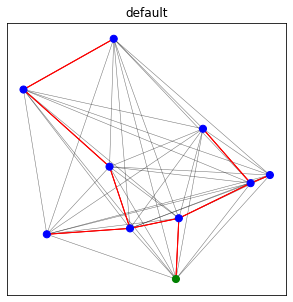

In [7]:
if notebook_mode:
    num_nodes = config.num_nodes
    num_neighbors = config.num_neighbors
    batch_size = 1
    train_filepath = config.train_filepath
    dataset = MSTReader(num_nodes, num_neighbors, batch_size, train_filepath)
    print("Number of batches of size {}: {}".format(batch_size, dataset.max_iter))

    t = time.time()
    batch = next(iter(dataset))  # Generate a batch of TSPs
    print("Batch generation took: {:.3f} sec".format(time.time() - t))

    print("edges:", batch.edges.shape)
    print("edges_values:", batch.edges_values.shape)
    print("edges_targets:", batch.edges_target.shape)
    print("nodes:", batch.nodes.shape)
    print("nodes_target:", batch.nodes_target.shape)
    print("nodes_coord:", batch.nodes_coord.shape)
    print("mst_edges:", batch.mst_edges.shape)
    print("mst_len:", batch.mst_len)

    idx = 0
    f = plt.figure(figsize=(5, 5))
    a = f.add_subplot(111)
    plot_tsp(a, batch.nodes_coord[idx], batch.edges[idx], batch.edges_values[idx], batch.edges_target[idx])

# Instantiate model

In [8]:
if notebook_mode == True:
    # Instantiate the network
    net = nn.DataParallel(ResidualGatedGCNModel(config, dtypeFloat, dtypeLong))
    if torch.cuda.is_available():
        net.cuda()
    print(net)

    # Compute number of network parameters
    nb_param = 0
    for param in net.parameters():
        nb_param += np.prod(list(param.data.size()))
    print('Number of parameters:', nb_param)
    
    # Define optimizer
    learning_rate = config.learning_rate
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    print(optimizer)

DataParallel(
  (module): ResidualGatedGCNModel(
    (nodes_coord_embedding): Linear(in_features=2, out_features=50, bias=False)
    (edges_values_embedding): Linear(in_features=1, out_features=25, bias=False)
    (edges_embedding): Embedding(3, 25)
    (gcn_layers): ModuleList(
      (0): ResidualGatedGCNLayer(
        (node_feat): NodeFeatures(
          (U): Linear(in_features=50, out_features=50, bias=True)
          (V): Linear(in_features=50, out_features=50, bias=True)
        )
        (edge_feat): EdgeFeatures(
          (U): Linear(in_features=50, out_features=50, bias=True)
          (V): Linear(in_features=50, out_features=50, bias=True)
        )
        (bn_node): BatchNormNode(
          (batch_norm): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )
        (bn_edge): BatchNormEdge(
          (batch_norm): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )
      )
      (1): ResidualGatedGC

# Load saved checkpoint

In [9]:
if notebook_mode==True:
    # Load checkpoint
    log_dir = f"./logs/{config.expt_name}/"
    if torch.cuda.is_available():
        checkpoint = torch.load(log_dir+"best_val_checkpoint.tar")
    else:
        checkpoint = torch.load(log_dir+"best_val_checkpoint.tar", map_location='cpu')
    # Load network state
    net.load_state_dict(checkpoint['model_state_dict'])
    # Load optimizer state
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # Load other training parameters
    epoch = checkpoint['epoch']
    train_loss = checkpoint['train_loss']
    val_loss = checkpoint['val_loss']
    for param_group in optimizer.param_groups:
        learning_rate = param_group['lr']
    print(f"Loaded checkpoint from epoch {epoch}")    

Loaded checkpoint from epoch 0


# Take y_preds, find its softmax, get the binary predictions and probabilities
y = F.softmax(y_preds, dim=3)  # B x V x V x voc_edges
y_bins = y.argmax(dim=3)  # Binary predictions: B x V x V
y_probs = y[:,:,:,1]  # Prediction probabilities: B x V x V

In [10]:
def _edges_to_node_pairs_torch(W, k, n):
    find_coords = lambda x, n: (x // n, x % n)
    vals, idxs = torch.topk(W.view(-1), k=k, dim=0)
    pairs = torch.unique(torch.Tensor([find_coords(idx,n) for idx in idxs]),dim=0)
    
#_edges_to_node_pairs_torch(y_probs[0], k=30, n=10)

In [11]:
# G is mst_pred_graph, n is the number of nodes in the graph
# Evaluator function
def is_spanning_tree(G):
    return nx.is_connected(G) and G.number_of_nodes()-1 == G.number_of_edges()
#is_spanning_tree(G)

# use the highest probability edge between two sets of nodes in the dfs traversal (if the graph is not )

def find_mst(G):
    num_iters = 0
    while(not is_spanning_tree(G) and num_iters<10000):
        n_nodes = G.number_of_nodes()-1
        n_edges = G.number_of_edges()
        if nx.is_connected(G):
            if n_edges > n_nodes:
                
        
        num_iters += 1
    return num_iters
find_mst(G)

In [12]:
def is_spanning_tree(G):
    return nx.is_connected(G) and G.number_of_nodes()-1 == G.number_of_edges()

def _edges_to_node_pairs(W, threshold = 0.25):
    """Helper function to convert edge matrix into pairs of adjacent nodes."""
    pairs = np.argwhere(W>threshold)
    pairs = np.unique(sorted([tuple(sorted(pair)) for pair in pairs]), axis=0)
    edge_preds = np.array([W[tuple(pair)] for pair in pairs])
    argsrt = np.argsort(edge_preds)[::-1]
    return pairs[argsrt].tolist(), edge_preds[argsrt].tolist()

def get_adjacency_matrix(edges, n):
    adjacency_matrix = np.zeros((n,n))
    for edge in edges:
        adjacency_matrix[tuple(edge)] = 1
    return adjacency_matrix

def test_mst(net, config, master_bar, mode='test'):
    # Set evaluation mode
    net.eval()

    # Assign parameters
    num_nodes = config.num_nodes
    num_edges = (num_nodes*num_nodes - num_nodes) // 2
    num_neighbors = config.num_neighbors
    batch_size = 1#config.batch_size
    batches_per_epoch = config.batches_per_epoch
    beam_size = 2#config.beam_size
    val_filepath = config.val_filepath
    test_filepath = config.test_filepath

    # Load TSP data
    if mode == 'val':
        dataset = MSTReader(num_nodes, num_neighbors, batch_size=batch_size, filepath=val_filepath)
    elif mode == 'test':
        dataset = MSTReader(num_nodes, num_neighbors, batch_size=batch_size, filepath=test_filepath)
    batches_per_epoch = dataset.max_iter

    # Convert dataset to iterable
    dataset = iter(dataset)
    
    # Initially set loss class weights as None
    edge_cw = None

    # Initialize running data
    running_loss = 0.0
    # running_err_edges = 0.0
    # running_err_tour = 0.0
    # running_err_tsp = 0.0
    running_pred_tour_len = 0.0
    running_gt_tour_len = 0.0
    running_nb_data = 0
    running_nb_batch = 0
    
    running_spanning_trees = 0
    
    with torch.no_grad():
        start_test = time.time()
        for batch_num in progress_bar(range(batches_per_epoch), parent=master_bar):
            # Generate a batch of TSPs
            try:
                batch = next(dataset)
            except StopIteration:
                break

            # Convert batch to torch Variables
            x_edges = Variable(torch.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
            x_edges_values = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
            x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
            x_nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
            y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)
            y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeLong), requires_grad=False)
            
            # Compute class weights (if uncomputed)
            if type(edge_cw) != torch.Tensor:
                edge_labels = y_edges.cpu().numpy().flatten()
                edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)

            # Forward pass
            y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw)
            loss = loss.mean()  # Take mean of loss across multiple GPUs
            print("Y_preds: ", y_preds.shape)
            # Compute error metrics
            # err_edges, err_tour, err_tsp, tour_err_idx, tsp_err_idx = edge_error(y_preds, y_edges, x_edges)
            
            y = F.softmax(y_preds, dim=3)  # B x V x V x voc_edges
            y_bins = y.argmax(dim=3)  # Binary predictions: B x V x V
            y_probs = y[:,:,:,1]  # Prediction probabilities: B x V x V
            for f_idx, idx in enumerate(range(0,len(y))):
                x_coord = x_nodes_coord[idx].cpu().numpy()
                W = x_edges[idx].cpu().numpy()
                W_val = x_edges_values[idx].cpu().numpy()
                W_target = y_edges[idx].cpu().numpy()
                W_sol_bins = y_bins[idx].cpu().numpy()
                W_sol_probs = y_probs[idx].cpu().numpy()
                
                # ignore self-pairs (set below the threshold of (0,1))
                for i in range(len(W_sol_probs)):
                    W_sol_probs[i,i] = -1

                n = len(W_sol_probs)
                G = nx.from_numpy_matrix(W_val)
                pos = dict(zip(range(len(x_coord)), x_coord.tolist()))
                node_pairs, edge_preds = _edges_to_node_pairs(W_sol_probs, threshold=0)
                #print("node-PAIRS", len(node_pairs), node_pairs)
                #print("edge_preds: ", type(edge_preds), edge_preds)
                G_mst_pred = nx.from_numpy_matrix(get_adjacency_matrix(node_pairs,n=n))
                #print(list(nx.dfs_postorder_nodes(G_mst_pred, source=np.random.choice(range(n)))))
                if is_spanning_tree(G_mst_pred):
                    running_spanning_trees += 1
                edge_preds = torch.Tensor([[edge_preds]]).cuda().expand(batch_size,len(edge_preds),len(edge_preds))              
            
            # Get batch beamsearch tour prediction
            if mode == 'val':  # Validation: faster 'vanilla' beamsearch
                bs_nodes = beamsearch_tour_nodes(
                    edge_preds, beam_size, batch_size, num_edges, dtypeFloat, dtypeLong, probs_type='logits')
            elif mode == 'test':  # Testing: beamsearch with shortest tour heuristic 
                bs_nodes = beamsearch_tour_nodes_shortest(
                    y_preds, x_edges_values, beam_size, batch_size, num_nodes, dtypeFloat, dtypeLong, probs_type='logits')
            #embed()
            print(bs_nodes)
            print(edge_preds)
            break

            # Compute mean tour length
            pred_tour_len = mean_tour_len_nodes(x_edges_values, bs_nodes)
            gt_tour_len = np.mean(batch.mst_len)

            # Update running data
            running_nb_data += batch_size
            running_loss += batch_size* loss.data.item()
            # running_err_edges += batch_size* err_edges
            # running_err_tour += batch_size* err_tour
            # running_err_tsp += batch_size* err_tsp
            running_pred_tour_len += batch_size* pred_tour_len
            running_gt_tour_len += batch_size* gt_tour_len
            running_nb_batch += 1

            # Log intermediate statistics
            #result = ('loss:{loss:.4f} pred_tour_len:{pred_tour_len:.3f} gt_tour_len:{gt_tour_len:.3f}'.format(
            #    loss=running_loss/running_nb_data,
            #    pred_tour_len=running_pred_tour_len/running_nb_data,
            #    gt_tour_len=running_gt_tour_len/running_nb_data))
            #master_bar.child.comment = result

    # Compute statistics for full epoch
    loss = running_loss/ running_nb_data
    err_edges = 0 # running_err_edges/ running_nb_data
    err_tour = 0 # running_err_tour/ running_nb_data
    err_tsp = 0 # running_err_tsp/ running_nb_data
    pred_tour_len = running_pred_tour_len/ running_nb_data
    gt_tour_len = running_gt_tour_len/ running_nb_data

    return time.time()-start_test, loss, err_edges, err_tour, err_tsp, pred_tour_len, gt_tour_len, running_spanning_trees

In [13]:
epoch_bar = master_bar(range(epoch+1, epoch+2))
config.batch_size = 1
for epoch in epoch_bar:
    # Set validation dataset as the test dataset so that we can perform 
    # greedy and vanilla beam search on test data without hassle!
    config.val_filepath = config.test_filepath
    t=time.time()
    val_time, val_loss, val_err_edges, val_err_tour, val_err_tsp, val_pred_tour_len, val_gt_tour_len, running_spanning_trees = test_mst(net, config, epoch_bar, mode='val')
    print("G time: {}s".format(time.time()-t))
    epoch_bar.write('G: ' + metrics_to_str(epoch, val_time, learning_rate, val_loss, val_err_edges, val_err_tour, val_err_tsp, val_pred_tour_len, val_gt_tour_len))
    print("Spanning Tree Percentage: ", (running_spanning_trees / 10000)*100)
    break

Y_preds:  torch.Size([1, 10, 10, 2])
Current State:  torch.Size([1, 2, 45]) tensor([[[40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
          40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
          40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40],
         [36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
          36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
          36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36]]], device='cuda:0')
Y:  torch.Size([1, 45, 45]) tensor([[[9.9560e-01, 9.8444e-01, 9.8278e-01,  ..., 7.0622e-06,
          5.5260e-06, 1.4826e-06],
         [9.9560e-01, 9.8444e-01, 9.8278e-01,  ..., 7.0622e-06,
          5.5260e-06, 1.4826e-06],
         [9.9560e-01, 9.8444e-01, 9.8278e-01,  ..., 7.0622e-06,
          5.5260e-06, 1.4826e-06],
         ...,
         [9.9560e-01, 9.8444e-01, 9.8278e-01,  ..., 7.0622e-06,
          5.5260e-06, 1.4826e-06],
         [9.9560e-01, 9.8444e-01, 9.8278e-01,

ValueError: not enough values to unpack (expected 2, got 0)